In [1]:
# Step 1: Import libraries and load data
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend
from keras.layers import Dropout
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\adeye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\adeye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Download stock data for Microsoft (ticker symbol: MSFT) from Yahoo Finance
msft = pd.read_csv("C:/Users/adeye/Downloads/MSFT.csv")

In [3]:
# Download gold data for gold (ticker symbol: GC=F) from Yahoo Finance
gold = pd.read_csv("C:/Users/adeye/Downloads/Gold.csv")

In [4]:
inflation = pd.read_csv("C:/Users/adeye/OneDrive/Desktop/BLS Inflation data time series.csv")

In [5]:
unemployment = pd.read_csv("C:/Users/adeye/OneDrive//Desktop/BLS Unemployment rate time series.csv")

In [6]:
merged_df = msft.copy()
merged_df = pd.merge(merged_df, inflation[['Date', 'Inflation']], on='Date', how='left')
merged_df = pd.merge(merged_df, gold[['Date', 'Close/Last']], on='Date', how='left')
merged_df = pd.merge(merged_df, unemployment[['Date', 'Unemployment']], on='Date', how='left')
df = merged_df

In [7]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Inflation,Close/Last,Unemployment
0,1/2/2013,27.250000,27.730000,27.150000,27.620001,22.72,52899300,0.2,NaN,8.0
1,1/3/2013,27.629999,27.650000,27.160000,27.250000,22.41,48294400,0.2,NaN,8.0
2,1/4/2013,27.270000,27.340000,26.730000,26.740000,21.99,52521100,0.2,NaN,8.0
3,1/7/2013,26.770000,26.879999,26.639999,26.690001,21.95,37110400,0.2,NaN,8.0
4,1/8/2013,26.750000,26.790001,26.459999,26.549999,21.84,44703100,0.2,NaN,8.0
...,...,...,...,...,...,...,...,...,...,...
2570,3/20/2023,276.980011,277.480011,269.850006,272.230011,272.23,43466600,NaN,1999.7,NaN
2571,3/21/2023,274.880005,275.000000,269.519989,273.779999,273.78,34558700,NaN,1941.1,NaN
2572,3/22/2023,273.399994,281.040009,272.179993,272.290009,272.29,34873300,NaN,1949.6,NaN
2573,3/23/2023,277.940002,281.059998,275.200012,277.660004,277.66,36610900,NaN,1995.9,NaN


In [8]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Inflation,Close/Last,Unemployment
0,1/2/2013,27.250000,27.730000,27.150000,27.620001,22.72,52899300,0.2,NaN,8.0
1,1/3/2013,27.629999,27.650000,27.160000,27.250000,22.41,48294400,0.2,NaN,8.0
2,1/4/2013,27.270000,27.340000,26.730000,26.740000,21.99,52521100,0.2,NaN,8.0
3,1/7/2013,26.770000,26.879999,26.639999,26.690001,21.95,37110400,0.2,NaN,8.0
4,1/8/2013,26.750000,26.790001,26.459999,26.549999,21.84,44703100,0.2,NaN,8.0
5,1/9/2013,26.719999,26.750000,26.559999,26.700001,21.96,49047900,0.2,NaN,8.0
6,1/10/2013,26.650000,26.980000,26.290001,26.459999,21.76,71431300,0.2,NaN,8.0
7,1/11/2013,26.490000,26.930000,26.280001,26.830000,22.07,55512100,0.2,NaN,8.0
8,1/14/2013,26.900000,27.080000,26.760000,26.889999,22.12,48324400,0.2,NaN,8.0
9,1/15/2013,26.830000,27.290001,26.830000,27.209999,22.38,48244500,0.2,NaN,8.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2575 entries, 0 to 2574
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2575 non-null   object 
 1   Open          2575 non-null   float64
 2   High          2575 non-null   float64
 3   Low           2575 non-null   float64
 4   Close         2575 non-null   float64
 5   Adj Close     2575 non-null   float64
 6   Volume        2575 non-null   int64  
 7   Inflation     2557 non-null   float64
 8   Close/Last    2518 non-null   float64
 9   Unemployment  2557 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 221.3+ KB


In [10]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Inflation,Close/Last,Unemployment
count,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2.575000e+03,2557.000000,2518.000000,2557.000000
mean,124.674054,125.936128,123.369565,124.717953,120.020730,3.227252e+07,0.207939,1446.053177,5.254752
std,90.942821,91.957887,89.867191,90.956959,91.853274,1.670179e+07,0.268588,264.827419,1.810415
min,26.490000,26.750000,26.280001,26.459999,21.760000,7.425600e+06,-0.800000,1049.600000,3.400000
25%,47.254999,47.695000,46.710001,47.299999,41.485000,2.248075e+07,0.100000,1244.225000,3.900000
50%,90.610001,92.459999,89.660004,91.269997,85.790000,2.837280e+07,0.200000,1319.100000,4.900000
75%,209.574997,212.040001,207.244996,209.764999,205.010000,3.673285e+07,0.300000,1734.600000,6.100000
max,344.619995,349.670013,342.200012,343.109985,339.080000,2.484285e+08,1.200000,2069.400000,14.700000


In [11]:
df.isnull().sum()

Date             0
Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
Inflation       18
Close/Last      57
Unemployment    18
dtype: int64

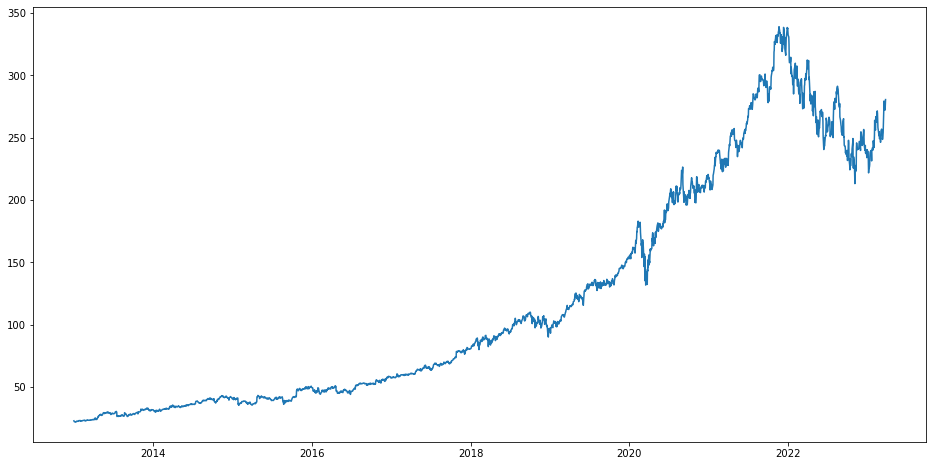

In [12]:
df["Date"]=pd.to_datetime(df.Date,format="%m/%d/%Y")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Adj Close"],label='Close Price history')

In [13]:
from sklearn.impute import KNNImputer

In [14]:
n_neighbors = 5

# create a k-NN imputer object
imputer = KNNImputer(n_neighbors=n_neighbors)

# loop over each column in the DataFrame
for column in df.columns:
    # get the column data as a numpy array
    column_data = df[column].values.reshape(-1, 1)
    
    # use k-NN imputation to fill in missing values
    imputer.fit(column_data)
    column_data_imputed = imputer.transform(column_data)
    
    # replace the original column with the imputed column
    df[column] = column_data_imputed.flatten()

print(df)

                    Date        Open        High         Low       Close  \
Date                                                                       
2013-01-02  1.357085e+18   27.250000   27.730000   27.150000   27.620001   
2013-01-03  1.357171e+18   27.629999   27.650000   27.160000   27.250000   
2013-01-04  1.357258e+18   27.270000   27.340000   26.730000   26.740000   
2013-01-07  1.357517e+18   26.770000   26.879999   26.639999   26.690001   
2013-01-08  1.357603e+18   26.750000   26.790001   26.459999   26.549999   
...                  ...         ...         ...         ...         ...   
2023-03-20  1.679270e+18  276.980011  277.480011  269.850006  272.230011   
2023-03-21  1.679357e+18  274.880005  275.000000  269.519989  273.779999   
2023-03-22  1.679443e+18  273.399994  281.040009  272.179993  272.290009   
2023-03-23  1.679530e+18  277.940002  281.059998  275.200012  277.660004   
2023-03-24  1.679616e+18  277.239990  280.630005  275.279999  280.570007   

           

In [15]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Inflation,Close/Last,Unemployment
Date,,,,,,,,,,
2013-01-02,1.357085e+18,27.250000,27.730000,27.150000,27.620001,22.72,52899300.0,0.2,1446.053177,8.0
2013-01-03,1.357171e+18,27.629999,27.650000,27.160000,27.250000,22.41,48294400.0,0.2,1446.053177,8.0
2013-01-04,1.357258e+18,27.270000,27.340000,26.730000,26.740000,21.99,52521100.0,0.2,1446.053177,8.0
2013-01-07,1.357517e+18,26.770000,26.879999,26.639999,26.690001,21.95,37110400.0,0.2,1446.053177,8.0
2013-01-08,1.357603e+18,26.750000,26.790001,26.459999,26.549999,21.84,44703100.0,0.2,1446.053177,8.0


In [16]:
df.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Inflation       0
Close/Last      0
Unemployment    0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2575 entries, 2013-01-02 to 2023-03-24
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2575 non-null   float64
 1   Open          2575 non-null   float64
 2   High          2575 non-null   float64
 3   Low           2575 non-null   float64
 4   Close         2575 non-null   float64
 5   Adj Close     2575 non-null   float64
 6   Volume        2575 non-null   float64
 7   Inflation     2575 non-null   float64
 8   Close/Last    2575 non-null   float64
 9   Unemployment  2575 non-null   float64
dtypes: float64(10)
memory usage: 221.3 KB


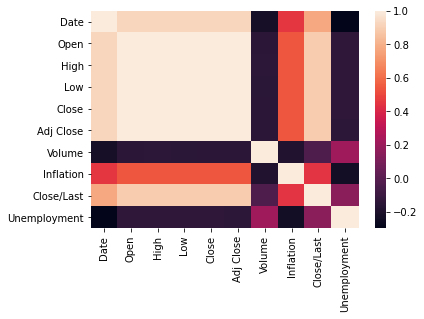

In [18]:
_ = sns.heatmap(df.corr())

In [19]:
Cleansed_df = df.drop(['Date', 'Volume', 'Open', 'Close', 'High', 'Low', 'Unemployment'], axis=1)

In [20]:
Cleansed_df.rename(columns = {'Close/Last':'Gold Price', 'Inflation':'Inflation Rate', 'Adj Close':'MSFT Stock Price'}, inplace = True)

In [21]:
Cleansed_df.head()

,MSFT Stock Price,Inflation Rate,Gold Price
Date,,,
2013-01-02,22.72,0.2,1446.053177
2013-01-03,22.41,0.2,1446.053177
2013-01-04,21.99,0.2,1446.053177
2013-01-07,21.95,0.2,1446.053177
2013-01-08,21.84,0.2,1446.053177


In [22]:
Cleansed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2575 entries, 2013-01-02 to 2023-03-24
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSFT Stock Price  2575 non-null   float64
 1   Inflation Rate    2575 non-null   float64
 2   Gold Price        2575 non-null   float64
dtypes: float64(3)
memory usage: 80.5 KB


In [23]:
Cleansed_df.shape

(2575, 3)

We have 3 feature columns and one target column. The target column is 'Adj Close' and there are 2543 rows to the data frame.¶

EDA for the data set

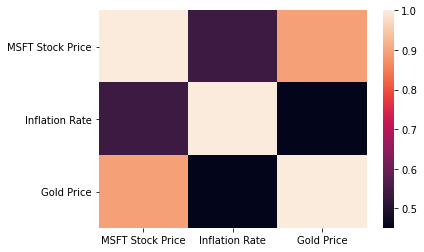

In [24]:
_ = sns.heatmap(Cleansed_df.corr())

In [25]:
# features creation by making it into a function

def create_features(Cleansed_df):
    """
    Create time series features based on time series index
    """
    Cleansed_df = Cleansed_df.copy()
    Cleansed_df['day of week'] = Cleansed_df.index.dayofweek
    Cleansed_df['quarter'] = Cleansed_df.index.quarter
    Cleansed_df['month'] = Cleansed_df.index.month
    Cleansed_df['year'] = Cleansed_df.index.year
    return Cleansed_df

Cleansed_df = create_features(Cleansed_df)

<AxesSubplot:xlabel='month', ylabel='MSFT Stock Price'>

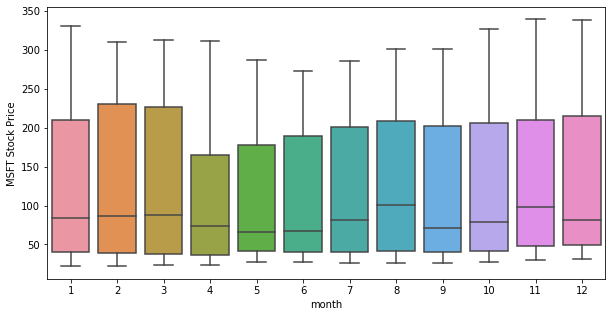

In [26]:
# We could vitualize our features

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=Cleansed_df, x='month', y='MSFT Stock Price')

<AxesSubplot:xlabel='quarter', ylabel='MSFT Stock Price'>

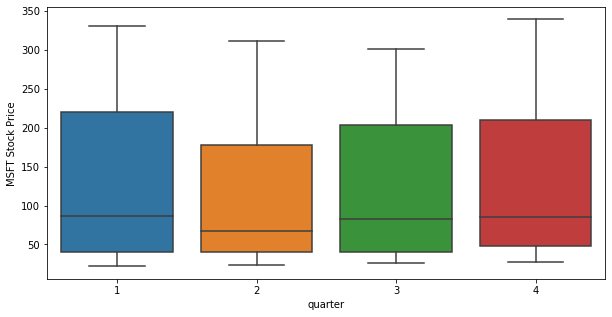

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=Cleansed_df, x='quarter', y='MSFT Stock Price')

<AxesSubplot:xlabel='year', ylabel='MSFT Stock Price'>

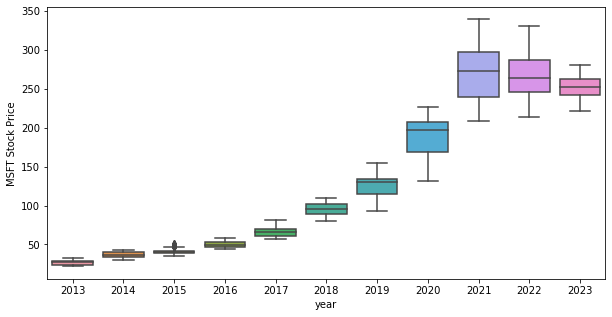

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=Cleansed_df, x='year', y='MSFT Stock Price')

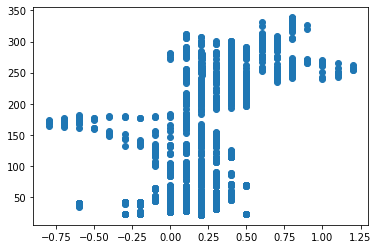

In [29]:
plt.scatter(Cleansed_df['Inflation Rate'],Cleansed_df['MSFT Stock Price'])

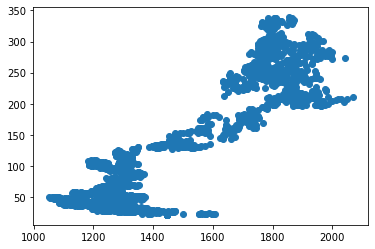

In [30]:
plt.scatter(Cleansed_df['Gold Price'],Cleansed_df['MSFT Stock Price'])

In [31]:
# Select relevant columns for analysis
Cleansed_df = Cleansed_df[['MSFT Stock Price', 'Inflation Rate', 'Gold Price']]

In [32]:
# Define helper functions to create the dataset for the LSTM model
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps, :])
        y.append(data[i+time_steps, 0])
    X, y = np.array(X), np.array(y)
    return X, y

# Set the time steps parameter
time_steps = 1

In [33]:
# Split the data into train, validation, and test sets
train_size = int(len(Cleansed_df) * 0.7)
val_size = int(len(Cleansed_df) * 0.1)
test_size = len(Cleansed_df) - train_size - val_size

train_data = Cleansed_df.iloc[:train_size, :]
val_data = Cleansed_df.iloc[train_size:train_size+val_size, :]
test_data = Cleansed_df.iloc[train_size+val_size:, :]

In [34]:
train_data

,MSFT Stock Price,Inflation Rate,Gold Price
Date,,,
2013-01-02,22.72,0.2,1446.053177
2013-01-03,22.41,0.2,1446.053177
2013-01-04,21.99,0.2,1446.053177
2013-01-07,21.95,0.2,1446.053177
2013-01-08,21.84,0.2,1446.053177
...,...,...,...
2020-02-24,166.17,0.1,1676.600000
2020-02-25,163.43,0.1,1650.000000
2020-02-26,165.47,0.1,1643.100000


In [35]:
# scaler for the target variable only
target_scaler = MinMaxScaler()
target_scaler.fit(np.array(train_data['MSFT Stock Price']).reshape(-1, 1))

MinMaxScaler()

In [36]:
# Scale the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

In [37]:
# Create the training, validation, and test datasets
X_train, y_train = create_dataset(train_data, time_steps)
X_val, y_val = create_dataset(val_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [38]:
X_train.shape

(1801, 1, 3)

In [39]:
y_train.shape

(1801,)

In [40]:
# Define and train the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, y_train, epochs=10, batch_size=6, validation_data=(X_val, y_val))


Epoch 1/10
301/301 [==============================] - 2s 3ms/step - loss: 0.0261 - val_loss: 0.0046
Epoch 2/10
301/301 [==============================] - 1s 2ms/step - loss: 5.6130e-04 - val_loss: 0.0093
Epoch 3/10
301/301 [==============================] - 0s 2ms/step - loss: 1.2381e-04 - val_loss: 0.0052
Epoch 4/10
301/301 [==============================] - 0s 2ms/step - loss: 1.0796e-04 - val_loss: 0.0051
Epoch 5/10
301/301 [==============================] - 0s 2ms/step - loss: 1.0011e-04 - val_loss: 0.0050
Epoch 6/10
301/301 [==============================] - 1s 2ms/step - loss: 9.6627e-05 - val_loss: 0.0032
Epoch 7/10
301/301 [==============================] - 0s 2ms/step - loss: 8.9532e-05 - val_loss: 0.0032
Epoch 8/10
301/301 [==============================] - 0s 2ms/step - loss: 8.6001e-05 - val_loss: 0.0028
Epoch 9/10
301/301 [==============================] - 0s 2ms/step - loss: 7.9882e-05 - val_loss: 0.0023
Epoch 10/10
301/301 [==============================] - 0s 2ms/step -

In [41]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', train_loss)
print('Validation loss:', val_loss)
print('Test loss:', test_loss)

Train loss: 6.39966456219554e-05
Validation loss: 0.0020971132908016443
Test loss: 0.004676228854805231


In [42]:
# Make predictions and visualize the results
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

17/17 [==============================] - 0s 937us/step


In [43]:
# y_train_pred_reshaped = y_train_pred.reshape(-1, 1)

In [44]:
y_train_pred_inverse = target_scaler.inverse_transform(y_train_pred)
y_val_pred_inverse = target_scaler.inverse_transform(y_val_pred)
y_test_pred_inverse = target_scaler.inverse_transform(y_test_pred)

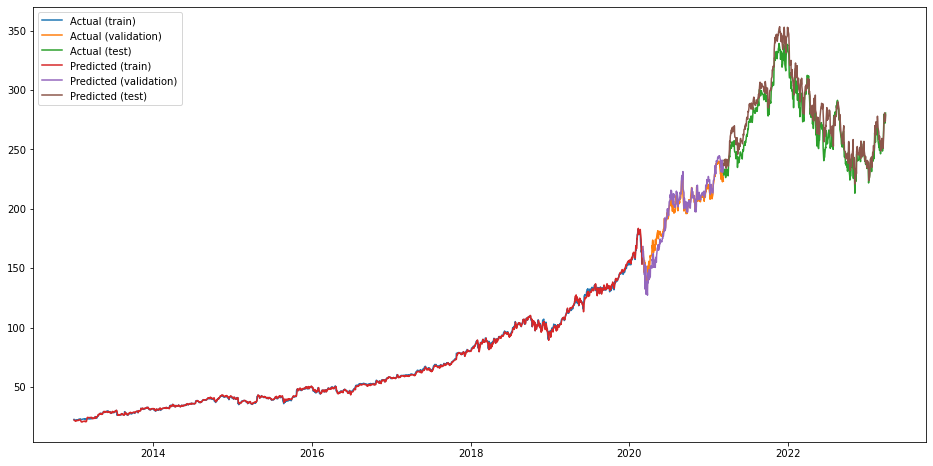

In [45]:
plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps:train_size+val_size], y_val_pred_inverse, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps:], y_test_pred_inverse, label='Predicted (test)')

plt.legend()
plt.show()

In [46]:
history.history

{'loss': [0.026129189878702164,
  0.0005612997920252383,
  0.00012381146370898932,
  0.00010796239075716585,
  0.00010010827099904418,
  9.662716183811426e-05,
  8.953249198384583e-05,
  8.600116416346282e-05,
  7.988185825524852e-05,
  8.472373156109825e-05],
 'val_loss': [0.004565832670778036,
  0.009341569617390633,
  0.0051673902198672295,
  0.005126980599015951,
  0.005046159029006958,
  0.003206128953024745,
  0.003172570839524269,
  0.0027781780809164047,
  0.0023228430654853582,
  0.0020971132908016443]}

<AxesSubplot:>

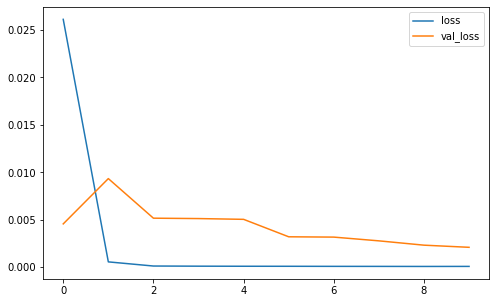

In [47]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [48]:
X_train.shape

(1801, 1, 3)

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3593
Train loss: 0.0009004117455333471
Validation loss: 0.04964444041252136
Test loss: 0.35933971405029297
17/17 [==============================] - 0s 2ms/step


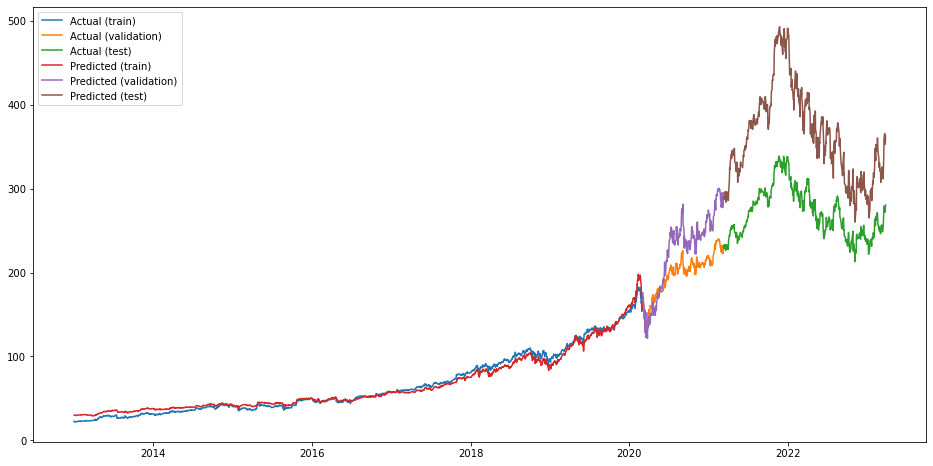

In [49]:
backend.clear_session()

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units=1))

lr = 0.0001

# Compiling the RNN
model.compile(loss='mse', optimizer=Adam(lr=lr))

history = model.fit(X_train, y_train, epochs=15, batch_size=10, validation_data=(X_val, y_val), verbose=3)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=1)
val_loss = model.evaluate(X_val, y_val, verbose=1)
test_loss = model.evaluate(X_test, y_test, verbose=1)
print('Train loss:', train_loss)
print('Validation loss:', val_loss)
print('Test loss:', test_loss)

# Make predictions and visualize the results
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

y_train_pred_inverse = target_scaler.inverse_transform(y_train_pred)
y_val_pred_inverse = target_scaler.inverse_transform(y_val_pred)
y_test_pred_inverse = target_scaler.inverse_transform(y_test_pred)

plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps:train_size+val_size], y_val_pred_inverse, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps:], y_test_pred_inverse, label='Predicted (test)')

plt.legend()
plt.show()

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Train loss: 0.0004455762973520905
Validation loss: 0.004128050059080124
Test loss: 0.018607130274176598
17/17 [==============================] - 0s 2ms/step


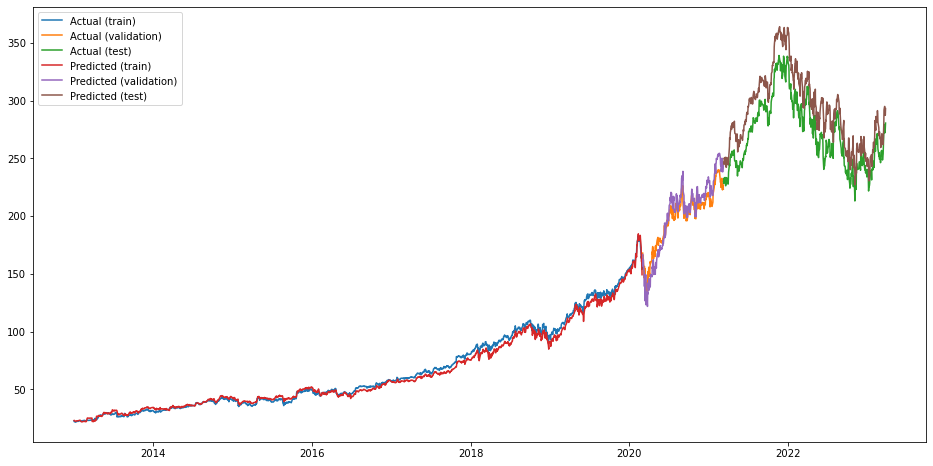

In [50]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units=50))
# Adding the output layer
model.add(Dense(units=1))

lr = 0.0001

# Compiling the RNN
model.compile(loss='mse', optimizer=Adam(lr=lr))

history = model.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_val, y_val), verbose=3)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=3)
val_loss = model.evaluate(X_val, y_val, verbose=3)
test_loss = model.evaluate(X_test, y_test, verbose=3)
print('Train loss:', train_loss)
print('Validation loss:', val_loss)
print('Test loss:', test_loss)

# Make predictions and visualize the results
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

y_train_pred_inverse = target_scaler.inverse_transform(y_train_pred)
y_val_pred_inverse = target_scaler.inverse_transform(y_val_pred)
y_test_pred_inverse = target_scaler.inverse_transform(y_test_pred)

plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps:train_size+val_size], y_val_pred_inverse, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps:], y_test_pred_inverse, label='Predicted (test)')

plt.legend()
plt.show()

In [51]:
from keras.optimizers import RMSprop

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
17/17 [==============================] - 0s 2ms/step - loss: 0.4290
Train loss: 0.0016321612056344748
Validation loss: 0.08878253400325775
Test loss: 0.42898714542388916
17/17 [==============================] - 0s 2ms/step


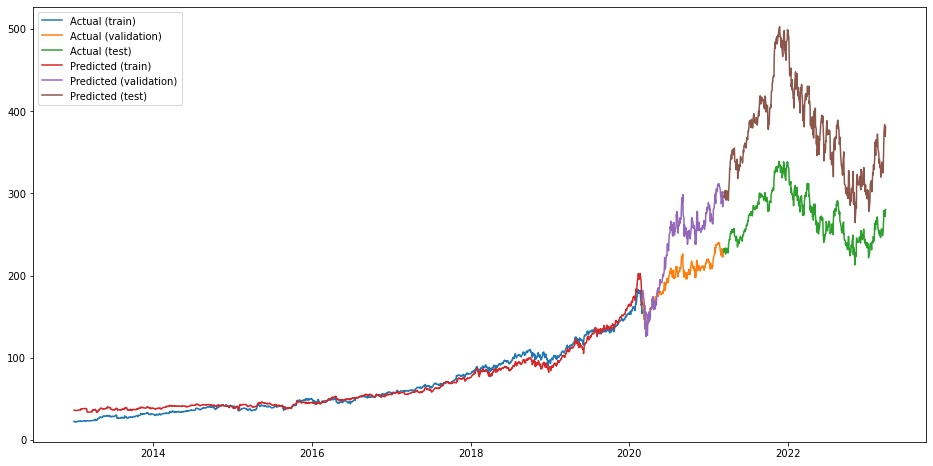

In [52]:
backend.clear_session()

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units=50))
# Adding the output layer
model.add(Dense(units=1))

lr = 0.0001

# Compiling the RNN
model.compile(loss='mse', optimizer=RMSprop(lr=lr))

history = model.fit(X_train, y_train, epochs=15, batch_size=10, validation_data=(X_val, y_val), verbose=3)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=1)
val_loss = model.evaluate(X_val, y_val, verbose=1)
test_loss = model.evaluate(X_test, y_test, verbose=1)
print('Train loss:', train_loss)
print('Validation loss:', val_loss)
print('Test loss:', test_loss)

# Make predictions and visualize the results
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

y_train_pred_inverse = target_scaler.inverse_transform(y_train_pred)
y_val_pred_inverse = target_scaler.inverse_transform(y_val_pred)
y_test_pred_inverse = target_scaler.inverse_transform(y_test_pred)

plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps:train_size+val_size], y_val_pred_inverse, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps:], y_test_pred_inverse, label='Predicted (test)')

plt.legend()
plt.show()

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Train loss: 0.0007137944339774549
Validation loss: 0.02904793992638588
Test loss: 0.2917826473712921
17/17 [==============================] - 0s 2ms/step


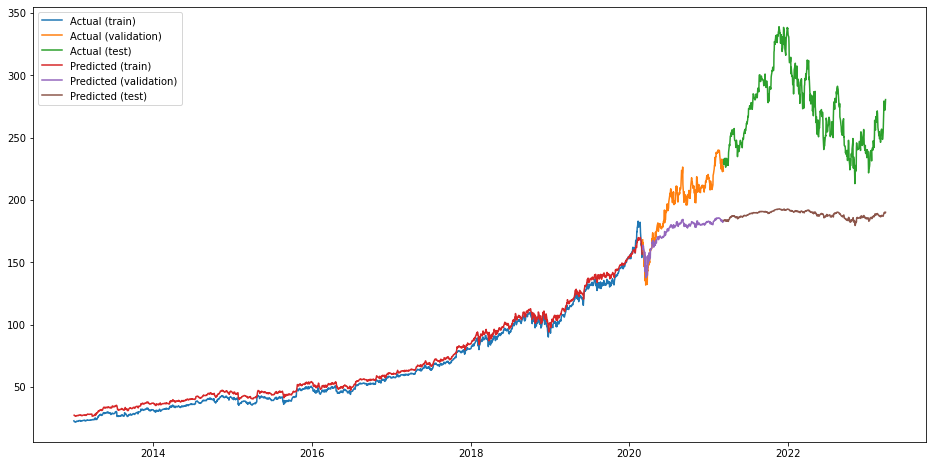

In [53]:
backend.clear_session()

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units=50))
# Adding the output layer
model.add(Dense(units=1))

lr = 0.002

# Compiling the RNN
model.compile(loss='mse', optimizer=RMSprop(lr=lr))

history = model.fit(X_train, y_train, epochs=15, batch_size=10, validation_data=(X_val, y_val), verbose=3)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=3)
val_loss = model.evaluate(X_val, y_val, verbose=3)
test_loss = model.evaluate(X_test, y_test, verbose=3)
print('Train loss:', train_loss)
print('Validation loss:', val_loss)
print('Test loss:', test_loss)

# Make predictions and visualize the results
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

y_train_pred_inverse = target_scaler.inverse_transform(y_train_pred)
y_val_pred_inverse = target_scaler.inverse_transform(y_val_pred)
y_test_pred_inverse = target_scaler.inverse_transform(y_test_pred)

plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps:train_size+val_size], y_val_pred_inverse, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps:], y_test_pred_inverse, label='Predicted (test)')

plt.legend()
plt.show()

Epoch 1/10
181/181 [==============================] - 9s 16ms/step - loss: 0.0816 - val_loss: 0.6159
Epoch 2/10
181/181 [==============================] - 1s 7ms/step - loss: 0.0410 - val_loss: 0.4054
Epoch 3/10
181/181 [==============================] - 1s 6ms/step - loss: 0.0296 - val_loss: 0.1369
Epoch 4/10
181/181 [==============================] - 1s 5ms/step - loss: 0.0150 - val_loss: 0.0210
Epoch 5/10
181/181 [==============================] - 1s 5ms/step - loss: 0.0060 - val_loss: 0.0751
Epoch 6/10
181/181 [==============================] - 1s 5ms/step - loss: 0.0052 - val_loss: 0.0662
Epoch 7/10
181/181 [==============================] - 1s 5ms/step - loss: 0.0037 - val_loss: 0.0630
Epoch 8/10
181/181 [==============================] - 1s 5ms/step - loss: 0.0035 - val_loss: 0.0328
Epoch 9/10
181/181 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0342
Epoch 10/10
17/17 [==============================] - 0s 2ms/step - loss: 0.2740
Train loss: 0.00054

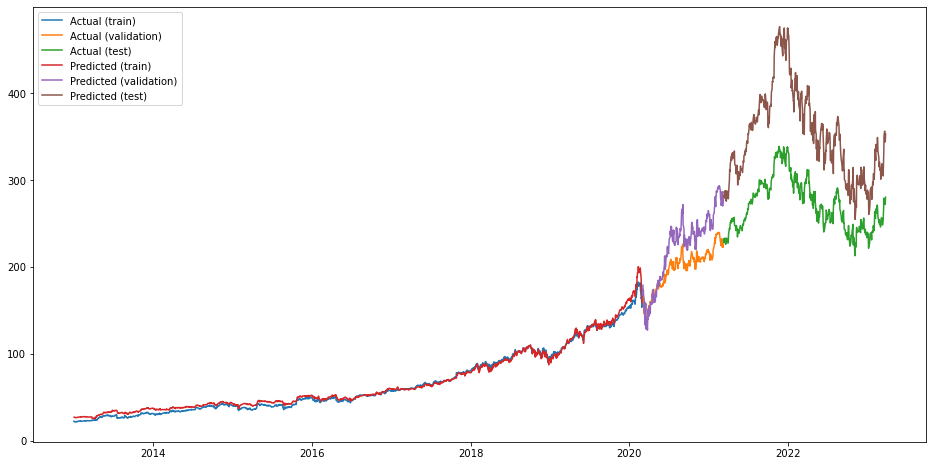

In [54]:
backend.clear_session()

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units=50))
# Adding the output layer
model.add(Dense(units=1))

lr = 0.0002

# Compiling the RNN
model.compile(loss='mse', optimizer=RMSprop(lr=lr))

history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=1)
val_loss = model.evaluate(X_val, y_val, verbose=1)
test_loss = model.evaluate(X_test, y_test, verbose=1)
print('Train loss:', train_loss)
print('Validation loss:', val_loss)
print('Test loss:', test_loss)

# Make predictions and visualize the results
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

y_train_pred_inverse = target_scaler.inverse_transform(y_train_pred)
y_val_pred_inverse = target_scaler.inverse_transform(y_val_pred)
y_test_pred_inverse = target_scaler.inverse_transform(y_test_pred)

plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps:train_size], y_train_pred_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps:train_size+val_size], y_val_pred_inverse, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps:], y_test_pred_inverse, label='Predicted (test)')

plt.legend()
plt.show()

# Using xgboost in prediction

# XGBOOST is an optimized boosting library under gradient boosting framework. It is an essemble of decision trees, new tree fix errors of previous trees, the new tree stop when no further improvement could be added to the model

# We need walk forward instead of kfold validation

In [55]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [56]:
# Define helper functions to create the dataset for the LSTM model
def create_dataset(data, time_steps_2):
    X_2, y_2 = [], []
    for i in range(len(data)-time_steps_2):
        X_2.append(data[i:i+time_steps_2, :])
        y_2.append(data[i+time_steps_2, 0])
    X_2, y_2 = np.array(X_2), np.array(y_2)
    return X_2, y_2

# Set the time steps parameter
time_steps_2 = 1

In [57]:
# Create the training, validation, and test datasets
X_2_train, y_2_train = create_dataset(train_data, time_steps_2)
X_2_val, y_2_val = create_dataset(val_data, time_steps_2)
X_2_test, y_2_test = create_dataset(test_data, time_steps_2)

In [58]:
X_2_train.shape

(1801, 1, 3)

In [59]:
X_2_test.shape

(515, 1, 3)

In [60]:
X_2_val.shape

(256, 1, 3)

In [61]:
X_2_train = X_2_train.reshape(X_2_train.shape[0], -1)
X_2_val = X_2_val.reshape(X_2_val.shape[0], -1)
X_2_test = X_2_test.reshape(X_2_test.shape[0], -1)

In [62]:
# fit model
from xgboost import XGBRegressor
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model_xgb.fit(X_2_train, y_2_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [63]:
X_2_train.shape

(1801, 3)

In [64]:
y_2_train.shape

(1801,)

In [65]:
X_2_test.shape

(515, 3)

In [66]:
y_2_test.shape

(515,)

In [67]:
# Make predictions and visualize the results
y_xgb_train_pred = model_xgb.predict(X_2_train)
mse = mean_squared_error(y_2_train, y_xgb_train_pred)
print('Validation MSE:', mse)

Validation MSE: 5.36964095020984e-06


In [68]:
y_xgb_val_pred = model_xgb.predict(X_2_val)
mse = mean_squared_error(y_2_val, y_xgb_val_pred)
print('Validation MSE:', mse)

Validation MSE: 0.05061232078187726


In [69]:
y_xgb_test_pred = model_xgb.predict(X_2_test)
mse = mean_squared_error(y_2_test, y_xgb_test_pred)
print('Validation MSE:', mse)

Validation MSE: 0.42247810636744465


In [70]:
y_xgb_train_pred = y_xgb_train_pred.reshape(-1, 1)
y_xgb_val_pred = y_xgb_val_pred.reshape(-1, 1)
y_xgb_test_pred = y_xgb_test_pred.reshape(-1, 1)

In [71]:
y_xgb_train_pred_inverse = target_scaler.inverse_transform(y_xgb_train_pred)
y_xgb_val_pred_inverse = target_scaler.inverse_transform(y_xgb_val_pred)
y_xgb_test_pred_inverse = target_scaler.inverse_transform(y_xgb_test_pred)

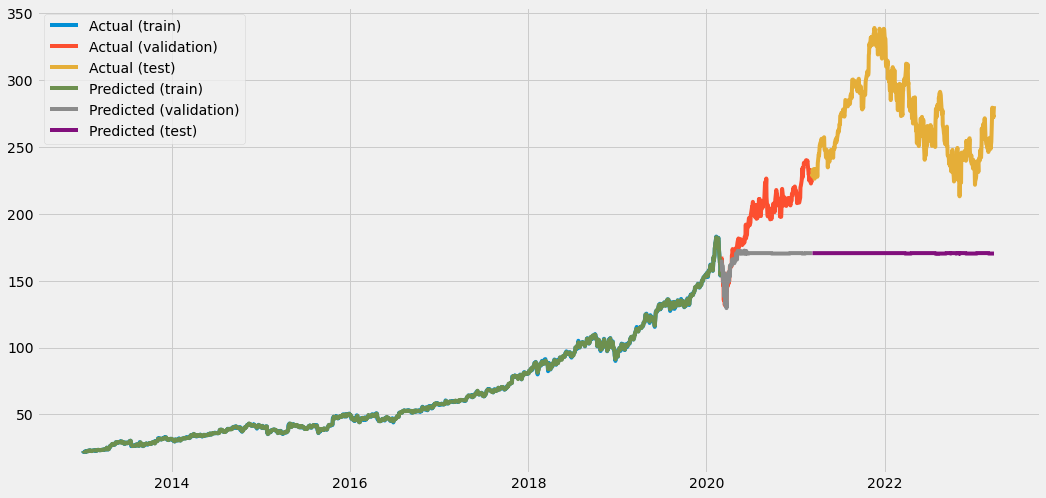

In [72]:
plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps_2:train_size], y_xgb_train_pred_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps_2:train_size+val_size], y_xgb_val_pred_inverse, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps_2:], y_xgb_test_pred_inverse, label='Predicted (test)')

plt.legend()
plt.show()

# Using RandomizedSearchCV to optimize the model

In [73]:
# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

In [74]:
params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 1]
}

In [75]:
model_xgb_rs = XGBRegressor(objective='reg:squarederror')
random_search = RandomizedSearchCV(model_xgb_rs, param_distributions=params, n_iter=100, cv=3, random_state=0)
random_search.fit(X_2_train, y_2_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                      

In [76]:
# best hyperparameters
print('Best hyperparameters:', random_search.best_params_)

Best hyperparameters: {'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1}


In [77]:
# early stopping
model_xgb_rs = XGBRegressor(objective='reg:squarederror', n_estimators=10000, early_stopping_rounds=10)
model_xgb_rs.fit(X_2_train, y_2_train, eval_set=[(X_2_val, y_2_val)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [78]:
# ensembling
from sklearn.ensemble import RandomForestRegressor

In [79]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=0)
model_rf.fit(X_2_train, y_2_train)

RandomForestRegressor(random_state=0)

In [80]:
y_xgb_test_pred = model_xgb.predict(X_2_test)
y_rf_test_pred = model_rf.predict(X_2_test)

In [81]:
y_xgb_train_pred = model_xgb.predict(X_2_train)
y_rf_train_pred = model_rf.predict(X_2_train)

In [82]:
y_xgb_val_pred = model_xgb.predict(X_2_val)
y_rf_val_pred = model_rf.predict(X_2_val)

In [83]:
y_ensemble_test_pred = (y_xgb_test_pred + y_rf_test_pred) / 2
mse = mean_squared_error(y_2_test, y_ensemble_test_pred)
print('Validation MSE:', mse)

Validation MSE: 0.40722881278100354


In [84]:
y_ensemble_train_pred = (y_xgb_train_pred + y_rf_train_pred) / 2
mse = mean_squared_error(y_2_train, y_ensemble_train_pred)
print('Validation MSE:', mse)

Validation MSE: 5.644427913183644e-06


In [85]:
y_ensemble_val_pred = (y_xgb_val_pred + y_rf_val_pred) / 2
mse = mean_squared_error(y_2_val, y_ensemble_val_pred)
print('Validation MSE:', mse)

Validation MSE: 0.04609817969815458


In [86]:
y_ensemble_train_pred = y_ensemble_train_pred.reshape(-1, 1)
y_ensemble_val_pred = y_ensemble_val_pred.reshape(-1, 1)
y_ensemble_test_pred = y_ensemble_test_pred.reshape(-1, 1)

In [87]:
y_ensemble_train_pred_inverse = target_scaler.inverse_transform(y_ensemble_train_pred)
y_ensemble_val_pred_inverse = target_scaler.inverse_transform(y_ensemble_val_pred)
y_ensemble_test_pred_inverse = target_scaler.inverse_transform(y_ensemble_test_pred)

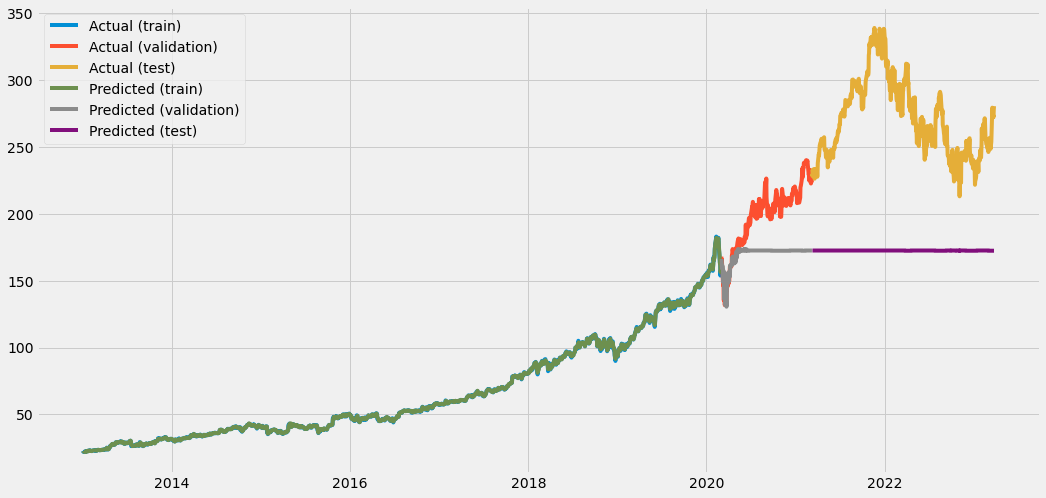

In [88]:
plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps_2:train_size], y_ensemble_train_pred_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps_2:train_size+val_size], y_ensemble_val_pred_inverse, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps_2:], y_ensemble_test_pred_inverse, label='Predicted (test)')

plt.legend()
plt.show()

# Using RandomForest

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [90]:
backend.clear_session()

rf = RandomForestRegressor(n_estimators=10,random_state=0)
rf.fit(X_2_train, y_2_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [91]:
y_rf_train_pred = rf.predict(X_2_train)
y_rf_val_pred = rf.predict(X_2_val)
y_rf_test_pred = rf.predict(X_2_test)

In [92]:
y_rf_train_pred = y_rf_train_pred.reshape(-1, 1)
y_rf_val_pred = y_rf_val_pred.reshape(-1, 1)
y_rf_test_pred = y_rf_test_pred.reshape(-1, 1)

In [93]:
y_rf_train_pred_inverse = target_scaler.inverse_transform(y_rf_train_pred)
y_rf_val_pred_inverse = target_scaler.inverse_transform(y_rf_val_pred)
y_rf_test_pred_inverse = target_scaler.inverse_transform(y_rf_test_pred)

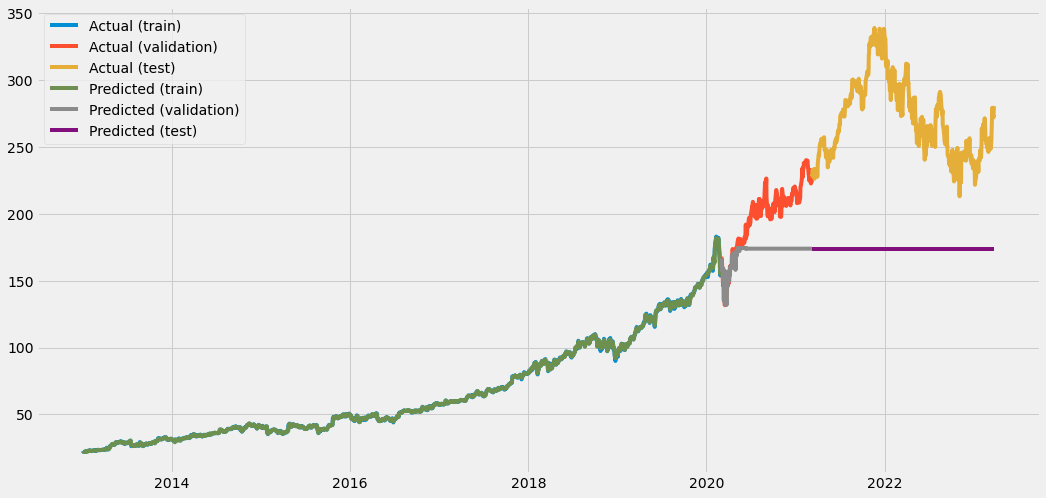

In [94]:
plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps_2:train_size], y_rf_train_pred_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps_2:train_size+val_size], y_rf_val_pred_inverse, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps_2:], y_rf_test_pred_inverse, label='Predicted (test)')

plt.legend()
plt.show()

# Using GridSearchCV to optimize the dataset

In [95]:
from sklearn.model_selection import GridSearchCV

In [96]:
# define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [97]:
# define the random forest regressor
rf = RandomForestRegressor(random_state=0)

# define the grid search
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)

# fit the grid search
grid_search.fit(X_2_train, y_2_train)

# print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best score:  -0.6608906486822734


In [98]:
# predict on the train, validation, and test sets
y_rf_train_pred_grid = grid_search.predict(X_2_train)
y_rf_val_pred_grid = grid_search.predict(X_2_val)
y_rf_test_pred_grid = grid_search.predict(X_2_test)

In [99]:
# evaluate the performance using MSE and RMSE
mse_train = mean_squared_error(y_2_train, y_rf_train_pred_grid)
rmse_train = np.sqrt(mse_train)
mse_val = mean_squared_error(y_2_val, y_rf_val_pred_grid)
rmse_val = np.sqrt(mse_val)
mse_test = mean_squared_error(y_2_test, y_rf_test_pred_grid)
rmse_test = np.sqrt(mse_test)

In [100]:
# print the performance metrics
print("Train MSE: ", mse_train, " Train RMSE: ", rmse_train)
print("Validation MSE: ", mse_val, " Validation RMSE: ", rmse_val)
print("Test MSE: ", mse_test, " Test RMSE: ", rmse_test)

Train MSE:  1.3573485523465979e-05  Train RMSE:  0.0036842211556129445
Validation MSE:  0.041430351758447295  Validation RMSE:  0.20354447120579644
Test MSE:  0.3907642188893183  Test RMSE:  0.6251113651896902


In [101]:
y_rf_train_pred_grid = y_rf_train_pred_grid.reshape(-1, 1)
y_rf_val_pred_grid = y_rf_val_pred_grid.reshape(-1, 1)
y_rf_test_pred_grid = y_rf_test_pred_grid.reshape(-1, 1)

In [102]:
y_rf_train_pred_grid_inverse = target_scaler.inverse_transform(y_rf_train_pred_grid)
y_rf_val_pred_grid_inverse = target_scaler.inverse_transform(y_rf_val_pred_grid)
y_rf_test_pred_grid_inverse = target_scaler.inverse_transform(y_rf_test_pred_grid)

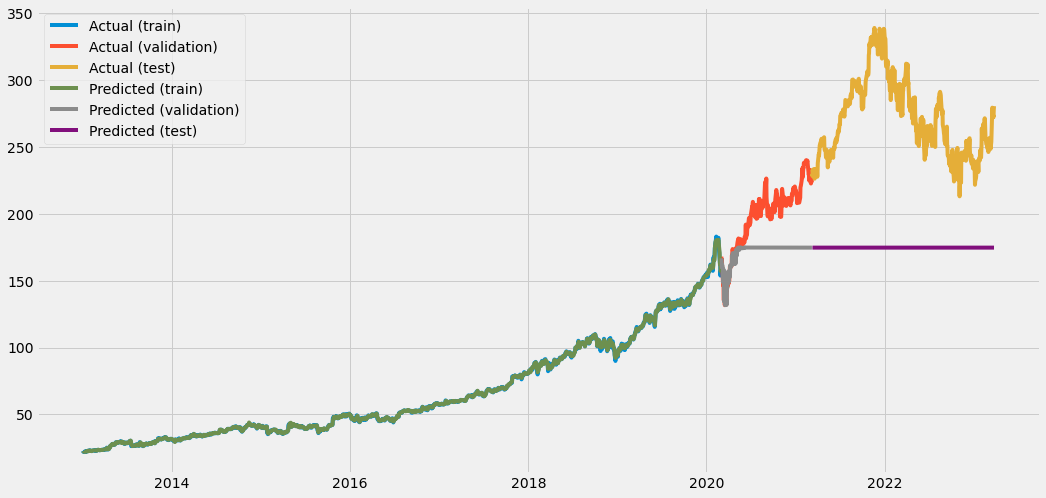

In [103]:
plt.figure(figsize=(16, 8))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps_2:train_size], y_rf_train_pred_grid_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps_2:train_size+val_size], y_rf_val_pred_grid_inverse, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps_2:], y_rf_test_pred_grid_inverse, label='Predicted (test)')

plt.legend()
plt.show()

# Using SVR

In [104]:
from sklearn.svm import SVR

In [105]:
backend.clear_session()

svr_model = SVR(kernel='rbf', epsilon=0.1)
svr_model.fit(X_2_train,y_2_train)

SVR()

In [106]:
# Make predictions and visualize the results
y_svr_train_pred = svr_model.predict(X_2_train)
mse = mean_squared_error(y_2_train, y_svr_train_pred)
print('Validation MSE:', mse)

Validation MSE: 0.0026644099614446443


In [107]:
y_svr_val_pred = svr_model.predict(X_2_val)
mse = mean_squared_error(y_2_val, y_svr_val_pred)
print('Validation MSE:', mse)

Validation MSE: 0.39949639535466497


In [108]:
y_svr_test_pred = svr_model.predict(X_2_test)
mse = mean_squared_error(y_2_test, y_svr_test_pred)
print('Validation MSE:', mse)

Validation MSE: 1.3640701007458313


In [109]:
y_svr_train_pred = y_svr_train_pred.reshape(-1, 1)
y_svr_val_pred = y_svr_val_pred.reshape(-1, 1)
y_svr_test_pred = y_svr_test_pred.reshape(-1, 1)

In [110]:
y_svr_train_pred_inverse = target_scaler.inverse_transform(y_svr_train_pred)
y_svr_val_pred_inverse = target_scaler.inverse_transform(y_svr_val_pred)
y_svr_test_pred_inverse = target_scaler.inverse_transform(y_svr_test_pred)

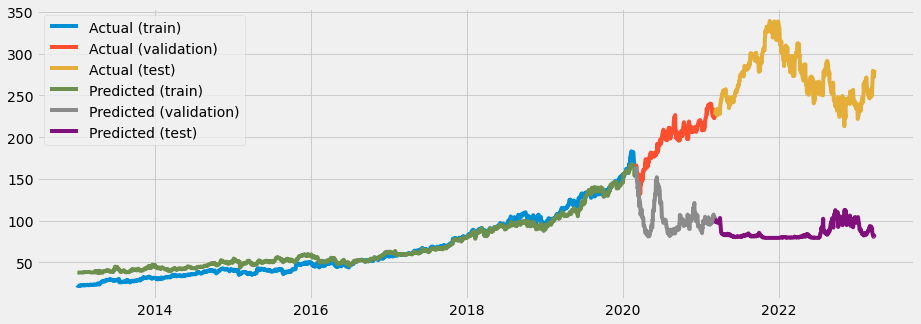

In [111]:
plt.figure(figsize=(14, 5))

plt.plot(Cleansed_df.index[:train_size], Cleansed_df.iloc[:train_size, 0], label='Actual (train)')
plt.plot(Cleansed_df.index[train_size:train_size+val_size], Cleansed_df.iloc[train_size:train_size+val_size, 0], label='Actual (validation)')
plt.plot(Cleansed_df.index[train_size+val_size:], Cleansed_df.iloc[train_size+val_size:, 0], label='Actual (test)')

plt.plot(Cleansed_df.index[time_steps_2:train_size], y_svr_train_pred_inverse, label='Predicted (train)')
plt.plot(Cleansed_df.index[train_size+time_steps_2:train_size+val_size], y_svr_val_pred_inverse, label='Predicted (validation)')
plt.plot(Cleansed_df.index[train_size+val_size+time_steps_2:], y_svr_test_pred_inverse, label='Predicted (test)')

plt.legend()
plt.show()